<font size = "+3"><strong>Air Pollution in Beijing </strong></font>

<font size = "+1"><strong>Forecast pollution level of a city every 6 hours using AR-Model</strong></font>

# Prepare

## Import

**Task 1:** Import all necessary libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings("ignore")

**Task 2:** Create a wrangle function to clean the dataset

In [21]:
# Create a wrangle function
def wrangle(filepath):
    df  = pd.read_csv(filepath)

    # Combine columns to create a timestamp
    df["timestamp"] = pd.to_datetime(df[["year","month","day","hour"]])
    df.index = df["timestamp"]


    # Mask to PM 2.5 readings not above 500
    df = df[df["pm2.5"] <= 500]

    # Localize the timestamp
    df.index = df.index.tz_localize("UTC").tz_convert("Asia/Hong_Kong")

    # Resample by 6 hours
    y = df
    y = df["pm2.5"].resample("6H").mean().fillna(method = "ffill")

    return y

y = wrangle("PRSA_data_2010.1.1-2014.12.31.csv")
y.head()

timestamp
2010-01-02 06:00:00+08:00    154.250000
2010-01-02 12:00:00+08:00    121.333333
2010-01-02 18:00:00+08:00    152.666667
2010-01-03 00:00:00+08:00    160.000000
2010-01-03 06:00:00+08:00     92.500000
Freq: 6H, Name: pm2.5, dtype: float64

**Task 3:** Inspect dataframe

In [ ]:
y.info()

## Explore

**Task 4 (a):** Check the presence of outliers in the target `"PM 2.5"` readings using a boxplot

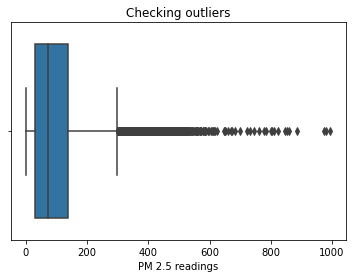

In [8]:
sns.boxplot(
    data = y,
    x = "pm2.5"
)
plt.xlabel("PM 2.5 readings")
plt.title("Checking outliers");

**Comment:** Readings above 500 are considered outliers

**Task 4 (b):** Check the presence of outliers in the target `"PM 2.5"` readings using a histogram

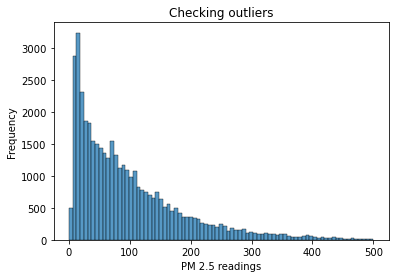

In [13]:
sns.histplot(
    data = y,
    x = "pm2.5"
)
plt.ylabel("Frequency")
plt.xlabel("PM 2.5 readings")
plt.title("Checking outliers");

**Comment:** Remove the outliers in the dataset

**Task 5:** Visualize the dataset after the outliers in the target `"PM 2.5"` have been removed

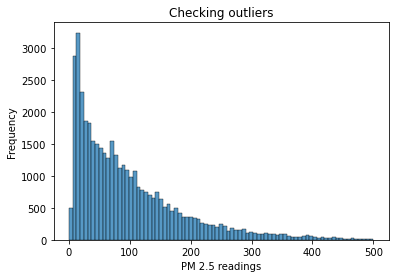

In [12]:
sns.histplot(
    data = y,
    x = "pm2.5"
)
plt.xlabel("PM 2.5 readings")
plt.ylabel("Frequency")
plt.title("Checking outliers");

**Task 6 (a):** Visualize the target `"PM 2.5"` on a line plot

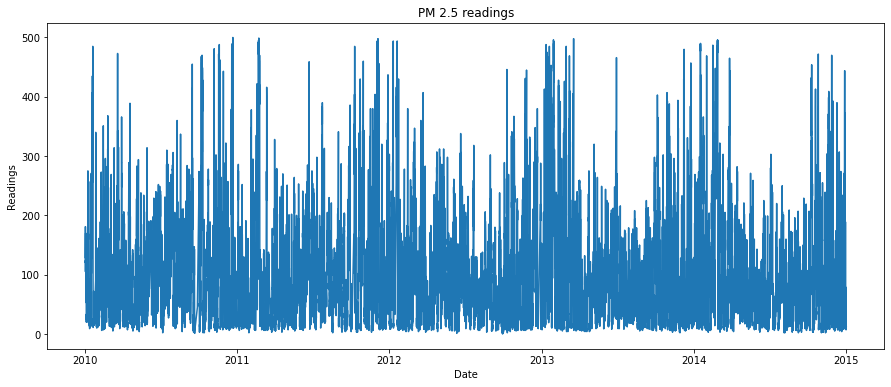

In [19]:
fig, ax = plt.subplots(figsize = [15, 6])
sns.lineplot(
    data = y,
    y = "pm2.5",
    x = "timestamp"
)
plt.title("PM 2.5 readings")
plt.xlabel("Date")
plt.ylabel("Readings");

**Comment:** Express the dataframe as a series

**Task 6(b):** Plot the rolling average of the target `"PM 2.5"` by 1 week to show weekly trends

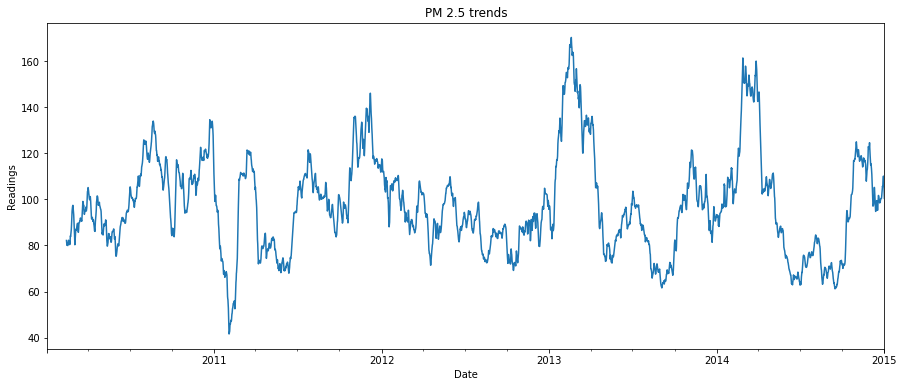

In [23]:
fig, ax = plt.subplots(figsize = [15, 6])
y.rolling(168).mean().plot()
plt.title("PM 2.5 trends")
plt.xlabel("Date")
plt.ylabel("Readings");

**Task 7:** Visualize the autocorrelation

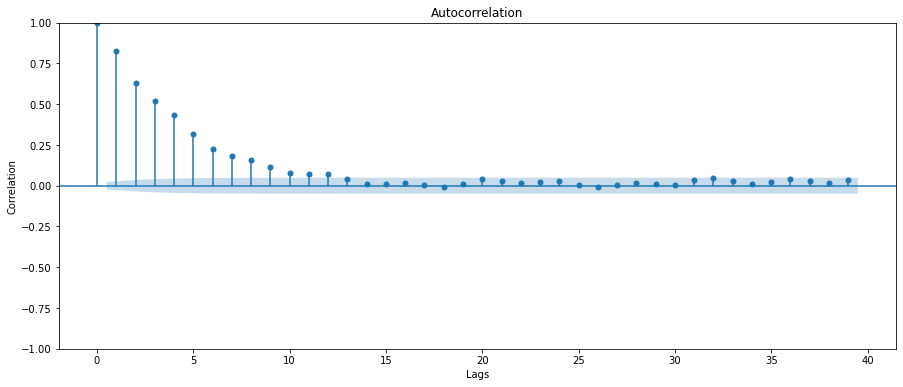

In [25]:
fig, ax = plt.subplots(figsize = [15, 6])
plot_acf(y, ax = ax)
plt.xlabel("Lags")
plt.ylabel("Correlation");

**Task 7 (b):** Visualize the partial autocorrelation

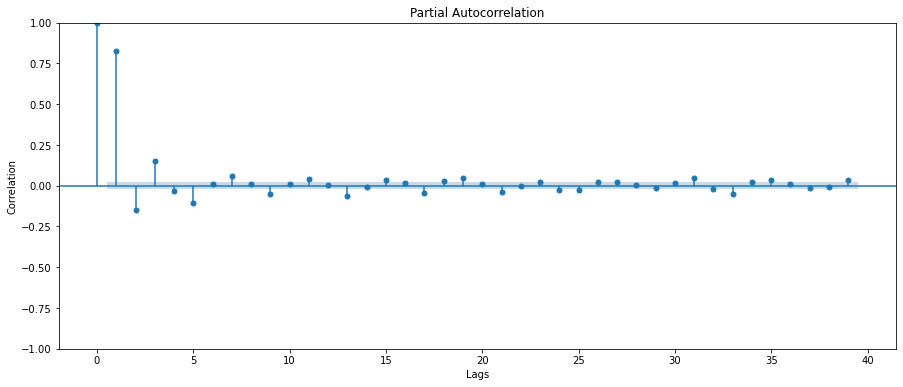

In [28]:
fig, ax = plt.subplots(figsize = [15, 6])
plot_pacf(y, method = 'ywm', ax = ax)
plt.xlabel("Lags")
plt.ylabel("Correlation");

**Comment:** Use a lag of 8 when building the AR-model

## Split

**Task 8:** Calculate the cut-off position

In [29]:
cut_off = int(len(y) * 0.95)
cut_off

6935

**Task 9:** Create a horizontal split

In [30]:
y_train, y_test = y.iloc[:cut_off],y.iloc[cut_off:]
y_train[:5]

timestamp
2010-01-02 06:00:00+08:00    154.250000
2010-01-02 12:00:00+08:00    121.333333
2010-01-02 18:00:00+08:00    152.666667
2010-01-03 00:00:00+08:00    160.000000
2010-01-03 06:00:00+08:00     92.500000
Freq: 6H, Name: pm2.5, dtype: float64

# Build Model

## Baseline

**Task 10:** Calculate the baseline mean absolute error of this model

In [32]:
mae_baseline = mean_absolute_error(y_train, [y_train.mean()] * len(y_train))
print("Baseline MAE:", round(mae_baseline, 2))

Baseline MAE: 63.58


## Iterate

**Task 11:** Initialize the number of lags

In [33]:
lag = 8

**Task 12:** Instantiate and fit the model

In [35]:
model = AutoReg(y_train, lags = lag).fit()

**Task 13:** Generate predictions

In [36]:
y_pred = model.predict().dropna()
y_pred[:5]

timestamp
2010-01-04 06:00:00+08:00    61.630015
2010-01-04 12:00:00+08:00    64.462991
2010-01-04 18:00:00+08:00    41.008847
2010-01-05 00:00:00+08:00    43.970643
2010-01-05 06:00:00+08:00    39.899441
Freq: 6H, dtype: float64

## Evaluate

**Task 14:** Calculate the training mean absolute error of this model

In [37]:
mae_train = mean_absolute_error(y_train.iloc[lag:], y_pred)
print("Training MAE:", round(mae_train, 2))

Training MAE: 31.37


**Task 15:** Calculate the test mean absolute error of this model

In [38]:
mae_test = mean_absolute_error(y_test, model.predict(y_test.index.min(),y_test.index.max()))
print("Test MAE:", round(mae_test, 2))

Test MAE: 84.4


**Comment:** The model overfits. New test predictions are needed

**Task 16:** Generate new test predictions using a walk forward validation

In [40]:
y_test_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model_wfv = AutoReg(history, lags = lag).fit()
    next_pred = model_wfv.forecast()
    y_test_wfv = y_test_wfv.append(next_pred)
    history = history.append(y_test[next_pred.index])
y_test_wfv.head()

2014-10-02 00:00:00+08:00    90.212955
2014-10-02 06:00:00+08:00    95.447688
2014-10-02 12:00:00+08:00    72.418708
2014-10-02 18:00:00+08:00    76.663988
2014-10-03 00:00:00+08:00    54.778714
Freq: 6H, dtype: float64

**Task 16:** Calculate the new test mean absolute error

In [41]:
mae_test = mean_absolute_error(y_test_wfv, y_test)
print("Test MAE:", round(mae_test, 2))

Test MAE: 38.23


**Task 17:** Genereate the residuals of the model

In [42]:
residuals = model.resid
residuals.head()

timestamp
2010-01-04 06:00:00+08:00    -5.463349
2010-01-04 12:00:00+08:00   -38.462991
2010-01-04 18:00:00+08:00   -12.675514
2010-01-05 00:00:00+08:00   -14.303977
2010-01-05 06:00:00+08:00   -10.566107
Freq: 6H, dtype: float64

**Task 18:** Visualize the model residuals on a histogram

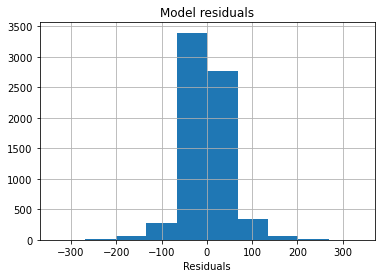

In [46]:
residuals.hist()
plt.title("Model residuals")
plt.xlabel("Residuals");

**Task 19:** Visualize the model residuals on a line plot

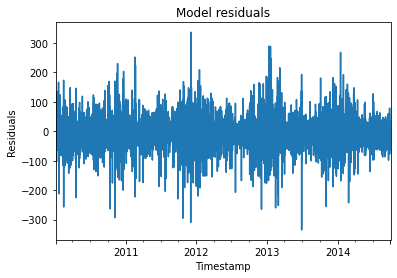

In [47]:
residuals.plot();
plt.title("Model residuals")
plt.ylabel("Residuals")
plt.xlabel("Timestamp");

# Communication

**Task 20:** Create a dataframe for the test predictions

In [51]:
data = {"Actual Readings" : y_test, "Model Readings" :y_test_wfv }
df_pred = pd.DataFrame(data)
df_pred.head()

,Actual Readings,Model Readings
2014-10-02 00:00:00+08:00,92.333333,90.212955
2014-10-02 06:00:00+08:00,74.000000,95.447688
2014-10-02 12:00:00+08:00,72.000000,72.418708
2014-10-02 18:00:00+08:00,49.500000,76.663988
2014-10-03 00:00:00+08:00,52.166667,54.778714


**Task 20:** Visualize the readings on a line plot

In [86]:
fig = px.line(
    df_pred,
    labels={"value": "P2"},
    title = "Time series of the PM 2.5 readings"
)
fig.update_layout(xaxis_title = "Date",yaxis_title = "PM 2.5 readings")
fig.show();